## Environment setup

Install dependencies:

In [ ]:
!pip install tensorflow_addons

tsai_stable = True # True: stable version in pip, False: latest version from github

if tsai_stable: 
  !pip install tsai -U >> /dev/null
else:      
  !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null




     |████████████████████████████████| 1.1 MB 12.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.5.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
googleapis-common-protos 1.54.0 requires protobuf>=3.12.0, but you have protobuf 3.11.2 which is incompatible.
google-api-core 1.26.3 requires protobuf>=3.12.0, but you have protobuf 3.11.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
sktime 0.9.0 requires statsmodels>=0.12.1, but you have statsmodels 0.10.2 which is incompatible.


Import modules:

In [ ]:
# math
import numpy as np
from numpy import array
from numpy.linalg import norm
import math

# os
import os
from os import F_OK
from os import listdir
from os.path import isfile, join
import sys

# ML
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from tsai.all import *  

# dataprep 
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime #timeseries - if needed

# visualisation
import matplotlib.pyplot as plt

# filesystem
from google.colab import drive
import pickle

# model weight loading for 'sequential' evaluation

# currently evaluated version/variant of the network
current_variant = ''

print("On: " + str(datetime.now()) + " -> Import successful")


On: 2022-01-25 16:39:51.262280 -> Import successful


Google Drive + directory markers:

In [ ]:
# define globally accessible variables == dir/file paths to the datasets; default -> for local training

# connect to the drive
drive.mount('/content/drive')

# dir/file paths to the datasets:

# 1. raw
datasets_file_path_raw = '/content/drive/MyDrive/raw_data_filepath' # + filename
fpath_dataset_raw_filenames = [f for f in listdir(datasets_file_path_raw) if isfile(join(datasets_file_path_raw, f))]

# 2. pickle 
datasets_file_path_pickle = '/content/drive/MyDrive/pickle_data_filepath' # + friction / + friction_classes
fpath_pickle_friction = datasets_file_path_pickle + 'friction.pickle'
fpath_pickle_friction_classes = datasets_file_path_pickle + 'friction_classes.pickle'


# working directories

notepad_dir = '/content/drive/MyDrive/notepad_directory'

model_data_dir = notepad_dir + 'Th06_models_and_output_data'

Mounted at /content/drive


## Data loading and preparation routine 

Load data:

In [ ]:
# load data from the defined filepath directories 

dataset_friction_file = open(fpath_pickle_friction, 'rb')
dataset_loaded = pickle.load(dataset_friction_file, encoding='latin1')
dataset_friction_file.close()

Preprocess x and y datasets

In [ ]:
# verify loaded data structures
dataset_loaded.keys()

dict_keys(['val_ds', 'train_ds', 'test_ds', 'signal_stats', 'classes_weights'])

In [ ]:
# prepare training data, list

from scipy.signal import savgol_filter

def prepare_x_y_data(dset: dict, collection: str, verbose: bool, drop_classes = [], compute_gradient= False,  smoothen = False, flip_dimensions = False):
  # dset: pickle dataset prepared by Mikołaj 
  # collection: marker that defines which subset of data to prepare - validation, training or test chunk
  # verbose: whether to display the 'load monit' or not
  # drop_classes: for the second part of the experiment -> load data without given classes of signals
  # compute_gradient: compute gradient of alongside the 0 axis of the dataframe (1-st order derivative of the signal, wrt. the timestep dn(Ts)/dTs) in x. 
  # normalize: apply scalling to x.
  # smoothen: perform smoothing on a x vector
  
  x = []
  y = []
  y_labels = []

  for i in range(len(dset[collection])):
    if dset[collection][i]['label'] in drop_classes:
        pass
    else:   
      if compute_gradient == True:
        x.append(np.gradient(dset[collection][i]['signal'], axis = 0))
      else:
        x.append(dset[collection][i]['signal'])

      y.append(dset[collection][i]['friction'])
      y_labels.append(dset[collection][i]['label'])
      
  if flip_dimensions == True:
    x_len = len(x)
    for i in range(x_len):
      x[i] = np.transpose(x[i])



  if smoothen == True:
    for i in range(len(x)):
      x[i] = savgol_filter(x[i], 31, 5, axis = 0)


  #if normalize == True:
  #  scaler = MinMaxScaler()
  #  x = scaler.fit_transform(x)



  if verbose == True:
    print('In ' + collection + ' -> x array length = ' + str(len(x)) + ' shape elements in x = ' + str(x[0].shape) )
    print('In ' + collection + ' -> y array length = ' + str(len(y)) + ' y[0] = ' + str(y[0]) )
    print('In ' + collection + ' -> y array length = ' + str(len(y_labels)) + ' y_labels[0] = ' + str(y_labels[0]) )



  return x,y,y_labels



# prepare label designations; for evaluation purposes

ENUM_LABELS = ['Artificial Grass',
               'Gum',
               'Carpet',
               'PVC',
               'Ceramic Tiles',
               'Foam',
               'Sand',
               'Rocks']



## Result evaluation function 

In [ ]:
def evaluate_results(y, y_hat, y_labels, save_plots = False, from_tsai = False, next_fig_idx = 0,save_as_handle = 'misc'):

  # display current variant
  print(current_variant)

  # tests_frame is a 2D array, where i in <0,7>, j in <0, i_th_category_len> 
  tests_frame = [[],[],[],[],[],[],[],[]]
  actual_coefficients = [0,0,0,0,0,0,0,0]

  # split tested data into arrays 
  for i in range(len(y)):
    
    predicted = 0.0 # predicted value placeholder

    if from_tsai == True:
      predicted = y_hat[2][i][0]  # obtain predicted value from tsai
    else:
      predicted = y_hat[i][0]     # obrain predicted value from keras, my convention

    
    actual = y[i]       # obtain actual value
  
    tested_material = int(y_labels[i]) 
    tests_frame[tested_material].append(predicted)
    actual_coefficients[tested_material] = actual


  # calculate average values of obtained predictions
  print('--- average values ---')
  average_values = [0,0,0,0,0,0,0,0]

  for i in range(len(average_values)):
    average_values[i] = np.average(np.asarray(tests_frame[i]))
    print('For class - ' + str(i) + ' average regressed value: ',average_values[i])


  # calculate percentage differences
  print("--- percentage differences ---")

  percentage_differences = [0,0,0,0,0,0,0,0]

  for i in range(len(percentage_differences)):
    percentage_differences[i] = 100*abs(1-average_values[i]/actual_coefficients[i])
    print('For class - ' + str(i) + ' difference from actual value: ', percentage_differences[i], "%")

  print('Avg percentage difference: ', np.nanmean(percentage_differences))

  # calculate percentage differences
  print("--- standard_deviations ---")

  standard_deviations = [0,0,0,0,0,0,0,0]

  for i in range(len(standard_deviations)):
    standard_deviations[i] = np.std(np.asarray(tests_frame[i]))
    print('For class - ' + str(i) + ' stdev: ', standard_deviations[i])

  print('Avg standard deviation: ', np.nanmean(standard_deviations))


  print('--- accuracy metrics for the entire vector of predictions ---')
  if from_tsai == True:
    print('1. Explained Variance: ' + str(skm.explained_variance_score(y,y_hat[2][:])))
    print('2. Max Error: ' + str(skm.max_error(y,y_hat[2][:])))
    print('3. Mean Absolute Error: ' + str(skm.mean_absolute_error(y,y_hat[2][:])))
    print('4. Root Mean Squared Error: '+str(skm.mean_squared_error(y,y_hat[2][:])))
    print('5. R2 score: '+ str(skm.r2_score(y,y_hat[2][:])))

  print('--- plots ---')

  for i in range(len(tests_frame)):
    if len(tests_frame[i]) >0:    
      plt.figure(i+next_fig_idx)
      figure = plt.gcf()
      figure.set_size_inches(10, 5)
      plt.scatter([i for i in range(len(tests_frame[i]))],tests_frame[i], label = 'predicted value', c = 'green', marker ='+')
      plt.plot(len(tests_frame[i])*[actual_coefficients[i]], label = 'actual value', marker = '.')
      plt.legend(loc = 'best')
      plt.title("Regression result: " + current_variant + " for '" + ENUM_LABELS[i].lower() + "' class of signals")
      plt.grid()
      plt.xlabel("Ordinal number of regression test $n$")
      plt.ylabel("Regressed friction coefficient $\mu(n)$")
      plt.tight_layout()
    
      if save_plots == True:
        plt.savefig(save_as_handle + '_reg_result_class_{}.png'.format(i), dpi = 200)

  plt.show()

## Architecture evaluation function

In [ ]:
# DEPENDENCIES; variables and functions that ought to be globally defined
# a. 'dataset_loaded' dictionary
# b. 'evaluate results' function
# c. 'tsai' framework - all its contents 



def evaluate_architecture_performance(tsai_architecture, test_folder_id_tag, load_model, save_model, training_epochs):

  # 1. define data for 'regular training' 
  # ... prepare datasets
  x_train, y_train, y_train_labels = prepare_x_y_data(dataset_loaded, 'train_ds', verbose = True, flip_dimensions=True)
  x_val, y_val, y_val_labels = prepare_x_y_data(dataset_loaded, 'val_ds',  verbose = True,flip_dimensions=True)
  x_test, y_test, y_test_labels = prepare_x_y_data(dataset_loaded, 'test_ds',  verbose = True, flip_dimensions=True)

  # ... prepare datasets -> fit for TSAI data fromatting, fit for split
  x_tsai = x_train +  x_val 
  y_tsai = y_train +  y_val 
  y_labels = y_train_labels +  y_val_labels
  

  # ... define the model handle 
  batch_tfms = [TSStandardize()]
  learn = TSRegressor(x_tsai, y_tsai, batch_tfms=batch_tfms,  bs = 16, metrics = mae, arch = tsai_architecture)
  
  if load_model == True:
    learn = load_all(model_data_dir+'/' + test_folder_id_tag + '/regular')
  else:
    learn.fit_one_cycle(training_epochs,1e-4)


  if save_model == True:
    learn.save_all(model_data_dir+'/' + test_folder_id_tag + '/regular')
  

  # ... predict the values 
  raw_preds = learn.get_X_preds(X = np.asarray(x_test), y = np.asarray(y_test), with_loss = True)

  evaluate_results(y_test, raw_preds, y_labels, save_plots = True, from_tsai = True, save_as_handle = model_data_dir+'/' + test_folder_id_tag + '/regular')


  # 2. define data for 'unknown terrain training' 

  # drop signals of classes: 
  x_train, y_train, y_train_labels = prepare_x_y_data(dataset_loaded, 'train_ds',verbose = True, drop_classes = [0,5],flip_dimensions=True)
  x_val, y_val, y_val_labels = prepare_x_y_data(dataset_loaded, 'val_ds',verbose = True, drop_classes = [0,5],flip_dimensions=True)
  x_test, y_test, y_test_labels = prepare_x_y_data(dataset_loaded, 'test_ds',verbose = True, drop_classes = [1,2,3,4,6,7],flip_dimensions=True)

  # augment the train dataset with all the signals not dropped for test
  x_train_aug, y_train_aug, y_train_labels_aug = prepare_x_y_data(dataset_loaded, 'test_ds',verbose = True, drop_classes =  [0,5],flip_dimensions=True)

  # ...
  x_train = x_train + x_train_aug
  y_train = y_train + y_train_aug
  y_train_labels = y_train_labels + y_train_labels_aug

  # augment the test dataset with Art. Grass & Foam classes of signals
  x_test_aug_1, y_test_aug_1, y_test_labels_aug_1 = prepare_x_y_data(dataset_loaded, 'train_ds',verbose = True, drop_classes = [1,2,3,4,6,7],flip_dimensions=True) # only 0, 5 labels remain
  x_test_aug_2, y_test_aug_2, y_test_labels_aug_2  = prepare_x_y_data(dataset_loaded, 'val_ds',verbose = True, drop_classes = [1,2,3,4,6,7],flip_dimensions=True)

  # ...
  x_test_tsai = x_test + x_test_aug_1 + x_test_aug_2
  y_test_tsai = y_test + y_test_aug_1 + y_test_aug_2
  y_test_labels = y_test_labels + y_test_labels_aug_1 + y_test_labels_aug_2

  # ... prepare datasets -> fit for TSAI data fromatting, fit for split
  x_tsai = x_train +  x_val 
  y_tsai = y_train +  y_val 
  y_labels = y_train_labels +  y_val_labels




  # ... define the model handle 
  batch_tfms = [TSStandardize()]
  learn = TSRegressor(x_tsai, y_tsai, batch_tfms=batch_tfms, loss_func= MSELossFlat(), bs = 16, metrics = mae, arch = tsai_architecture)
  
  if load_model == True:
    learn = load_all(model_data_dir+'/' + test_folder_id_tag + '/unknown_terrain')
  else:
    learn.fit_one_cycle(training_epochs,1e-4)


  if save_model == True:
    learn.save_all(model_data_dir+'/' + test_folder_id_tag + '/unknown_terrain')
  

  # ... predict the values es
  

  raw_preds = learn.get_X_preds(X = np.asarray(x_test_tsai), y = np.asarray(y_test_tsai), with_loss = True)

  evaluate_results(y_test_tsai, raw_preds, y_test_labels, save_plots = True, from_tsai = True, next_fig_idx = 6, save_as_handle = model_data_dir+'/' + test_folder_id_tag + '/unknown_terrain')



# Architecture 1: Timeseries Transformer; 

- Trained over 200, przepisać evaluate_architecture

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


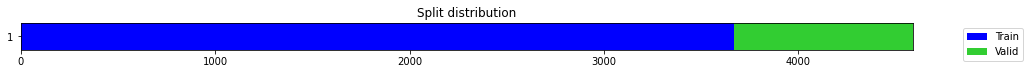


--- average values ---
For class - 0 average regressed value:  1.144326124612878
For class - 1 average regressed value:  1.151349883666612
For class - 2 average regressed value:  1.0804642977551644
For class - 3 average regressed value:  1.0540194838654762
For class - 4 average regressed value:  1.1421900204447812
For class - 5 average regressed value:  1.113962022860845
For class - 6 average regressed value:  1.0804030688369974
For class - 7 average regressed value:  1.1119714787868267
--- percentage differences ---
For class - 0 difference from actual value:  115.54538018896761 %
For class - 1 difference from actual value:  66.72167646804306 %
For class - 2 difference from actual value:  45.643656852037864 %
For class - 3 difference from actual value:  83.18671647829876 %
For class - 4 difference from actual value:  98.51059932234119 %
For class - 5 difference from actual value:  18.299411580873226 %
For class - 6 difference from actual value:  87.77213674219591 %
For class - 7 diff

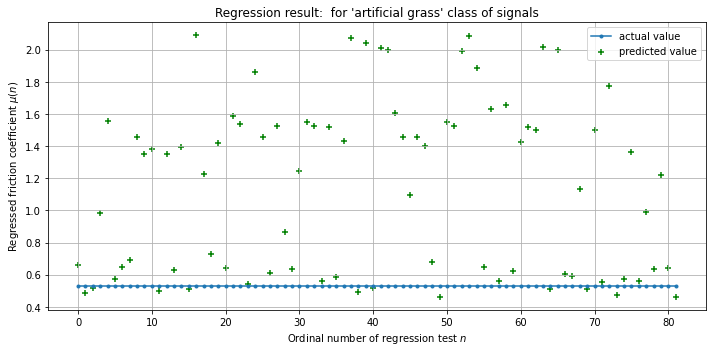

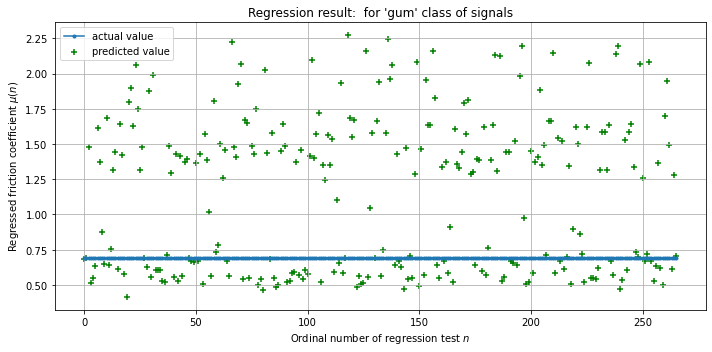

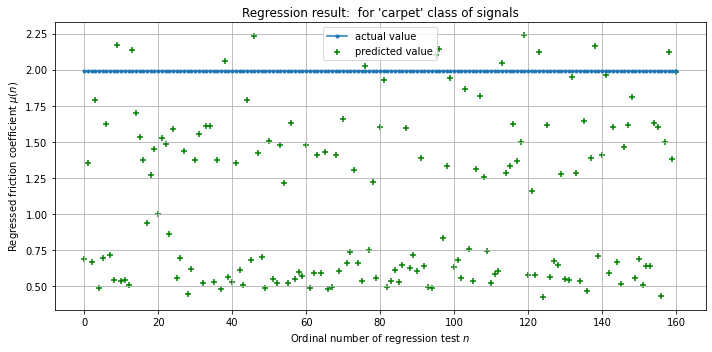

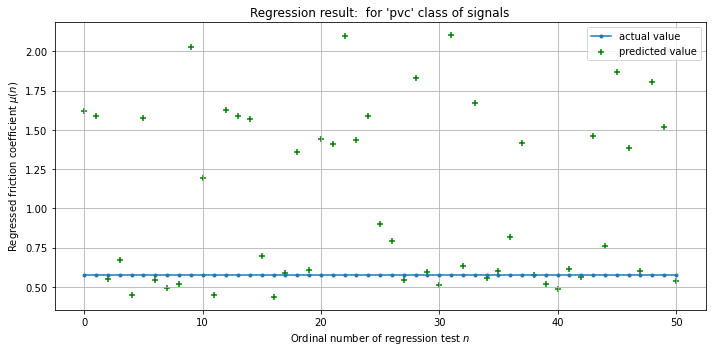

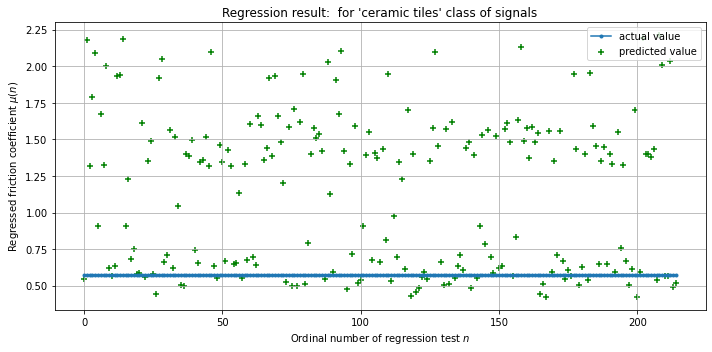

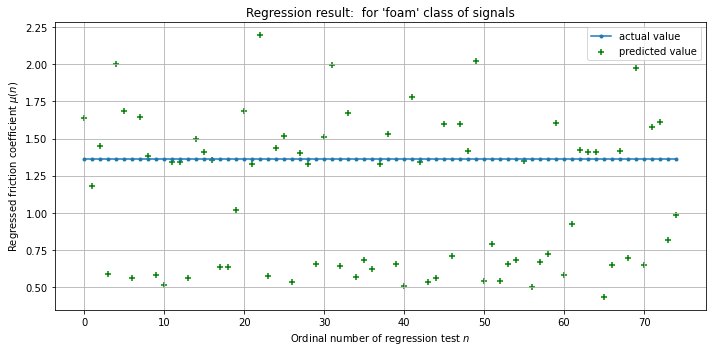

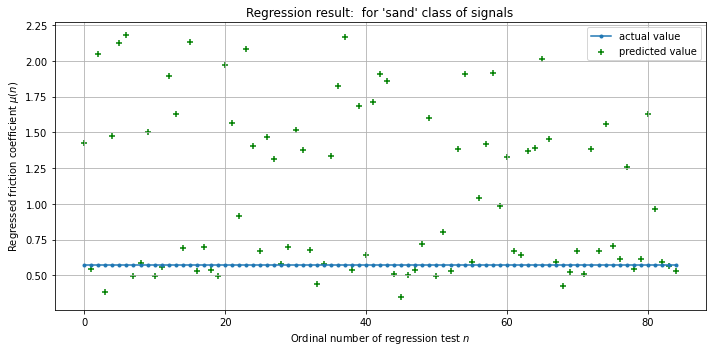

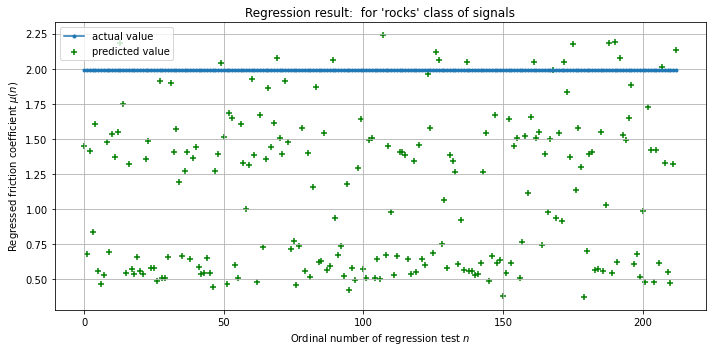

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

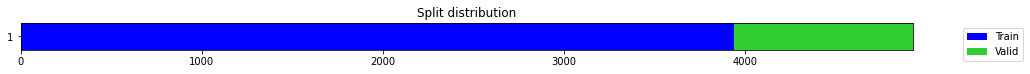


--- average values ---
For class - 0 average regressed value:  1.259285754580006
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.1832832536636255
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  17.31463316400028 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  25.474105680477354 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  21.394369422238817
--- standard_deviations ---
For class - 0 stdev:  0.39747601792850146
For class 

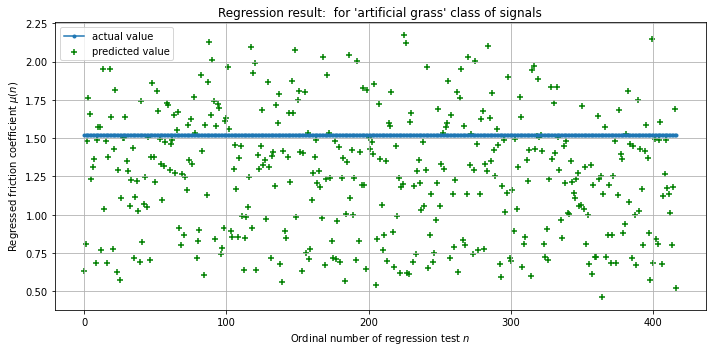

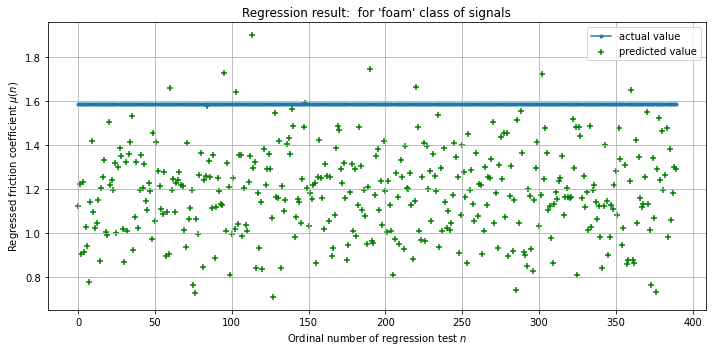

In [ ]:
evaluate_architecture_performance(TST, 'tst_1_transformer', True, False,350)

# Architecture 2: Timeseries Transformer +

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


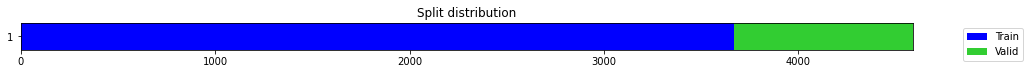


--- average values ---
For class - 0 average regressed value:  1.1365804494154164
For class - 1 average regressed value:  1.1263020026280468
For class - 2 average regressed value:  1.0537132219127987
For class - 3 average regressed value:  1.076418132758608
For class - 4 average regressed value:  1.1181707032891206
For class - 5 average regressed value:  1.100083810488383
For class - 6 average regressed value:  1.0685344657477212
For class - 7 average regressed value:  1.0958457527585992
--- percentage differences ---
For class - 0 difference from actual value:  114.08640405502508 %
For class - 1 difference from actual value:  63.094608121605525 %
For class - 2 difference from actual value:  46.98945852367652 %
For class - 3 difference from actual value:  87.07956192099913 %
For class - 4 difference from actual value:  94.33608461065876 %
For class - 5 difference from actual value:  19.317272238388107 %
For class - 6 difference from actual value:  85.7093945800347 %
For class - 7 diff

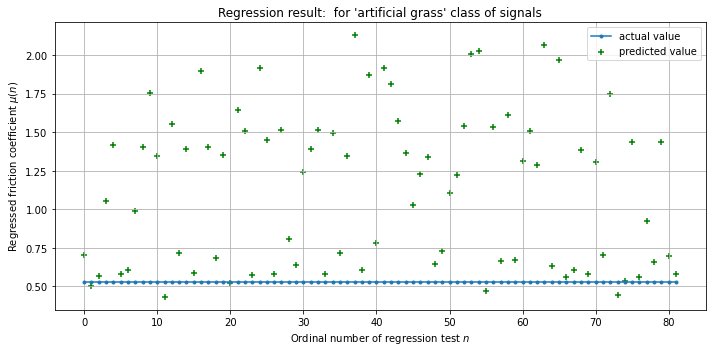

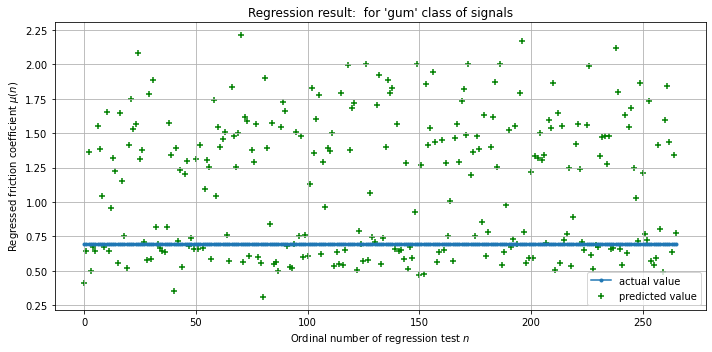

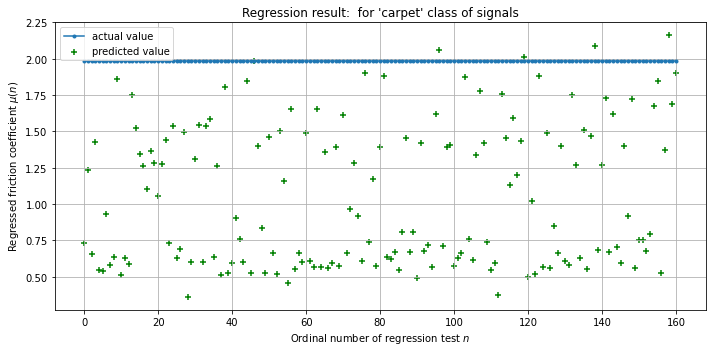

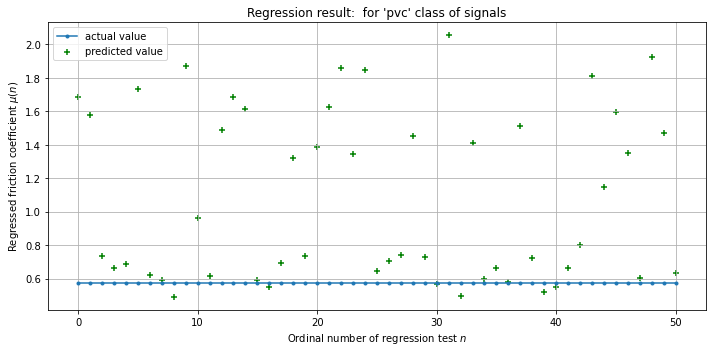

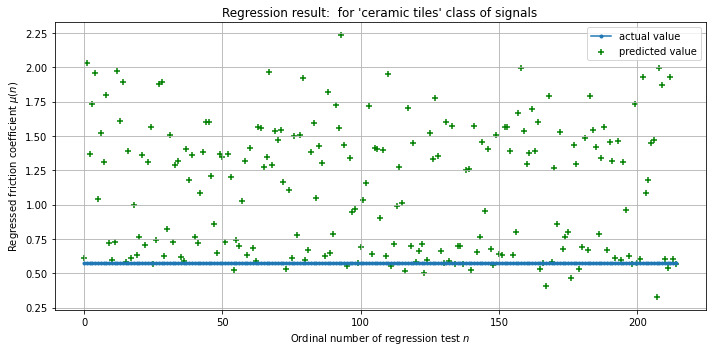

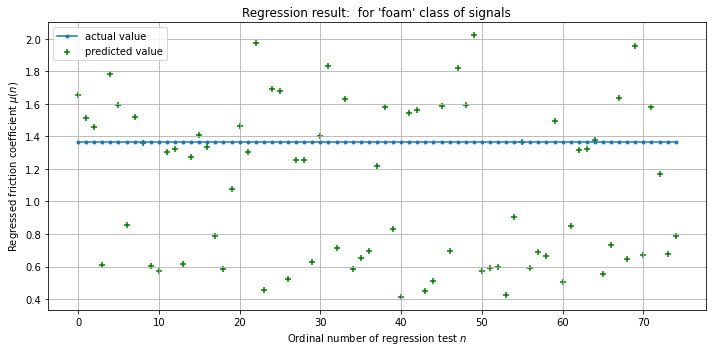

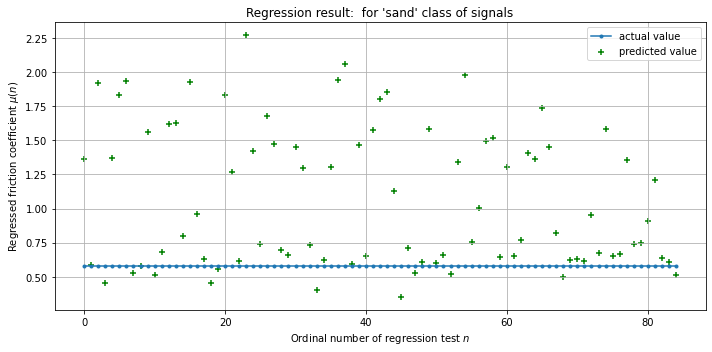

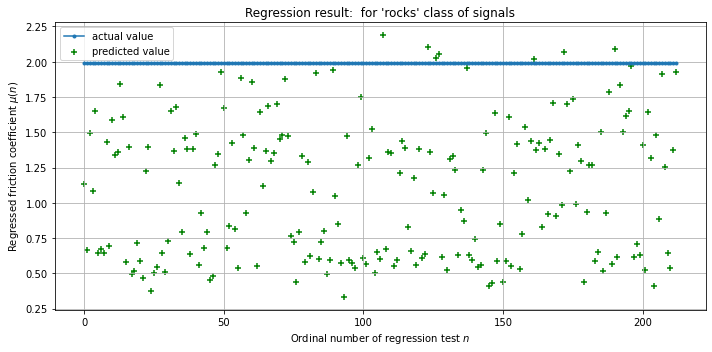

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

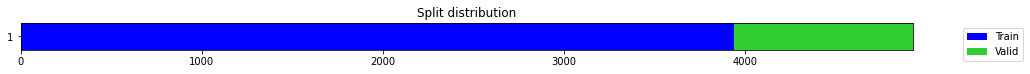


--- average values ---
For class - 0 average regressed value:  1.217339292847567
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.1836942124061096
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  20.068859965347453 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  25.448222555944632 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  nan
--- standard_deviations ---
For class - 0 stdev:  0.3768154928403529
For class - 1 stdev:  nan

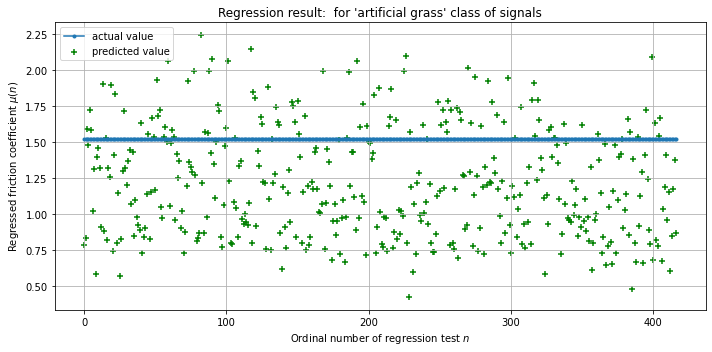

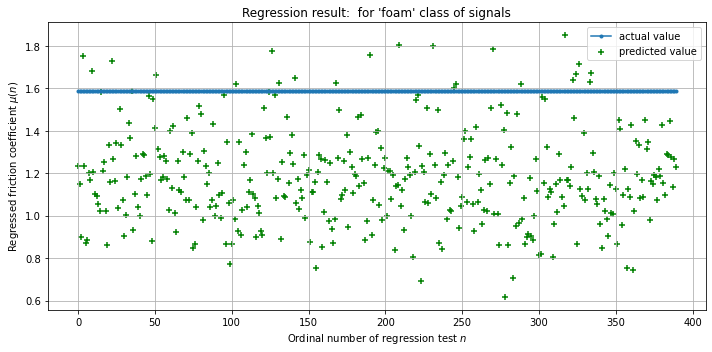

In [ ]:
evaluate_architecture_performance(TSTPlus, 'tst_2_transformer_plus', True, False,350)

# Architecture 3: LSTM_FCN

https://github.com/titu1994/LSTM-FCN see the paper
https://www.researchgate.net/figure/Network-architecture-of-MRNN-FCN-MBiRNN-FCN-MBiLSTM-FCN-MGRU-FCN-and-MBiGRU-FCN_fig3_344202978

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


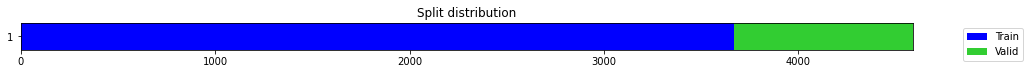


--- average values ---
For class - 0 average regressed value:  1.1223265499603459
For class - 1 average regressed value:  1.1413699897160208
For class - 2 average regressed value:  1.0975890707525406
For class - 3 average regressed value:  1.0486925010587655
For class - 4 average regressed value:  1.1291331130404805
For class - 5 average regressed value:  1.1051761587460835
For class - 6 average regressed value:  1.0697735099231496
For class - 7 average regressed value:  1.1140957922442978
--- percentage differences ---
For class - 0 difference from actual value:  111.40153816658977 %
For class - 1 difference from actual value:  65.27653396703626 %
For class - 2 difference from actual value:  44.782138299957694 %
For class - 3 difference from actual value:  82.26089631649404 %
For class - 4 difference from actual value:  96.24133197826588 %
For class - 5 difference from actual value:  18.94378746911315 %
For class - 6 difference from actual value:  85.92473825967512 %
For class - 7 di

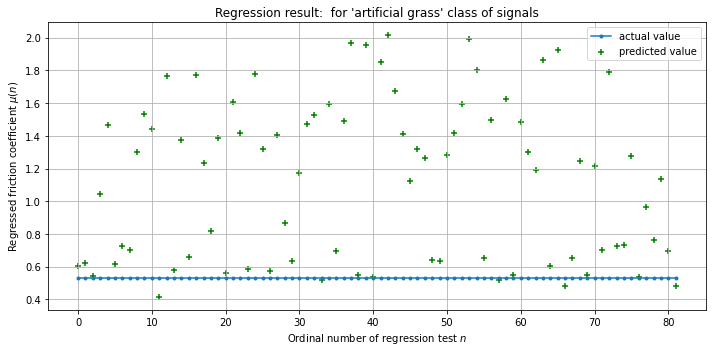

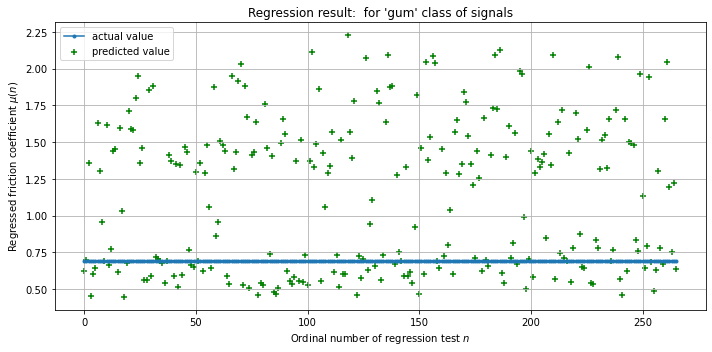

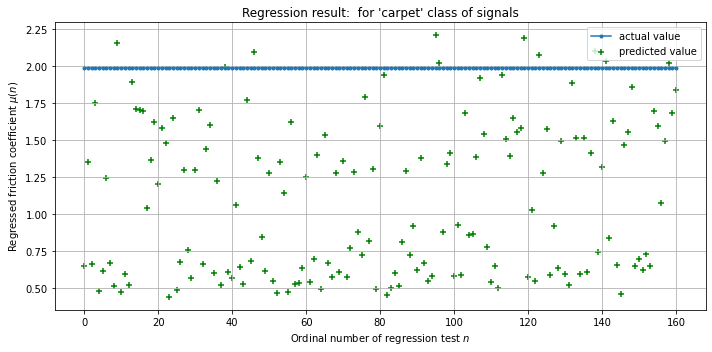

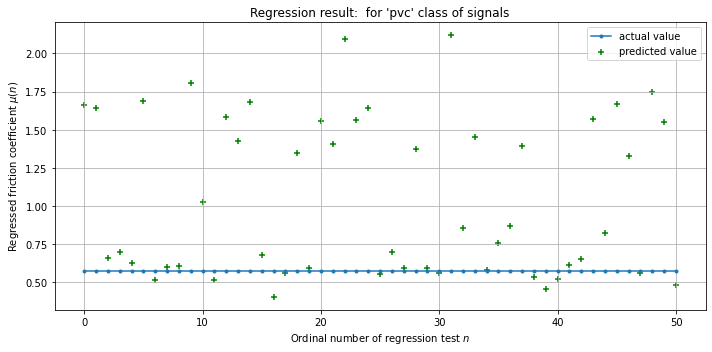

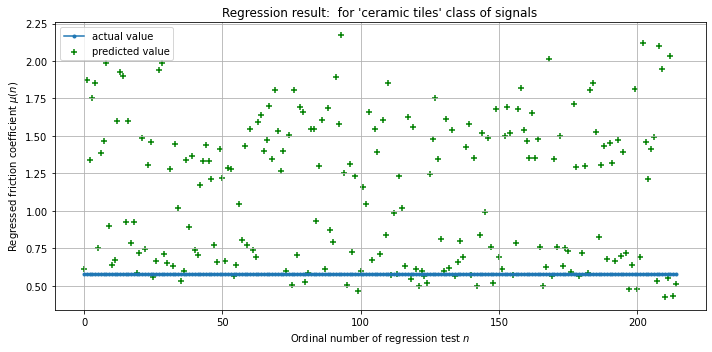

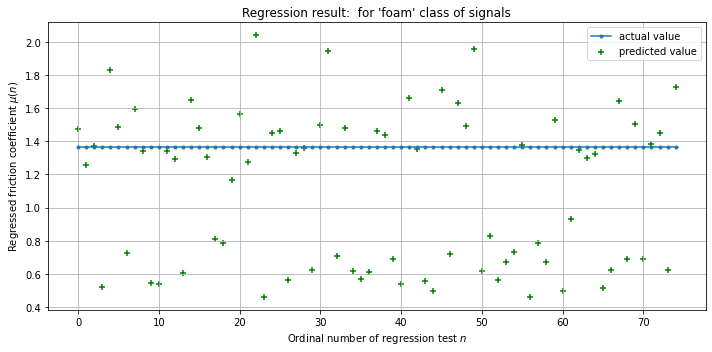

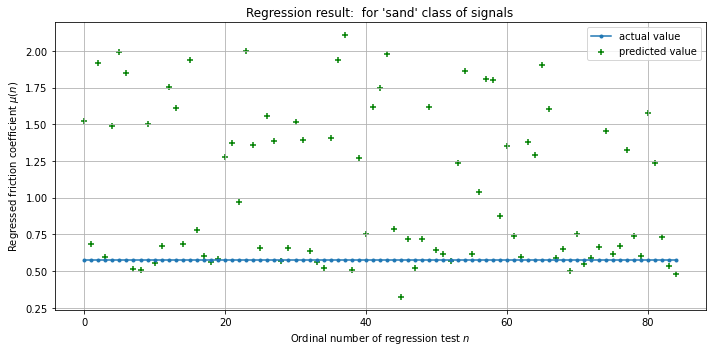

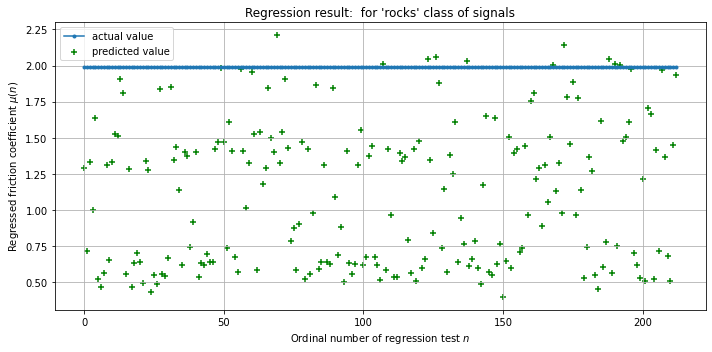

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

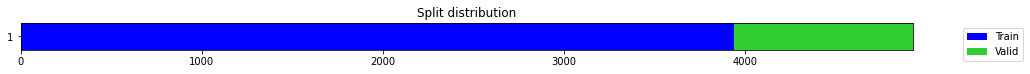


--- average values ---
For class - 0 average regressed value:  1.2514382227719258
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.2086223136156033
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  17.82990624157488 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  23.878193545077544 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  20.854049893326213
--- standard_deviations ---
For class - 0 stdev:  0.42864689514824494
For class

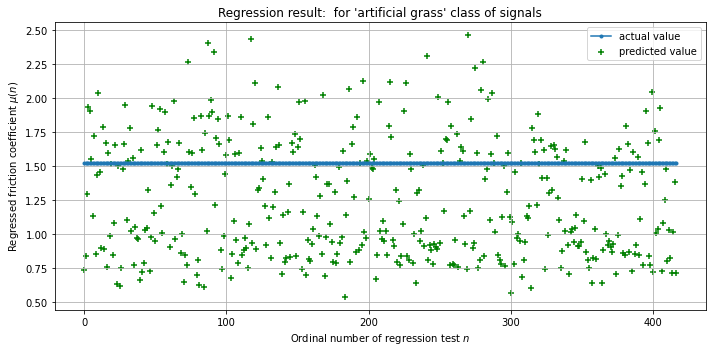

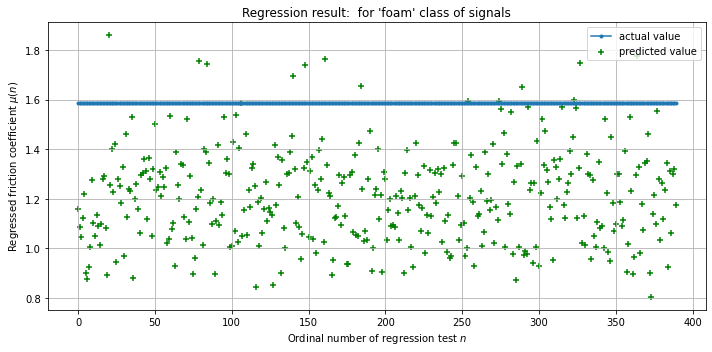

In [ ]:
evaluate_architecture_performance(LSTM_FCN, 'tst_3_lstm_fcn',  True, False ,350)

# Architecture 4: multilevel Wavelet Decomposition Network

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


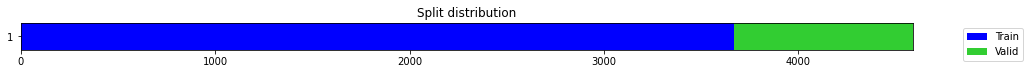


--- average values ---
For class - 0 average regressed value:  1.1269506128822886
For class - 1 average regressed value:  1.1392064757813187
For class - 2 average regressed value:  1.0834739622862444
For class - 3 average regressed value:  1.0297124806572409
For class - 4 average regressed value:  1.1295802900957508
For class - 5 average regressed value:  1.1055689175923666
For class - 6 average regressed value:  1.089280940504635
For class - 7 average regressed value:  1.0979518947746831
--- percentage differences ---
For class - 0 difference from actual value:  112.27252710854461 %
For class - 1 difference from actual value:  64.96324547378798 %
For class - 2 difference from actual value:  45.49224568708634 %
For class - 3 difference from actual value:  78.96220244103036 %
For class - 4 difference from actual value:  96.3190505571853 %
For class - 5 difference from actual value:  18.914981613806038 %
For class - 6 difference from actual value:  89.31509508879687 %
For class - 7 diff

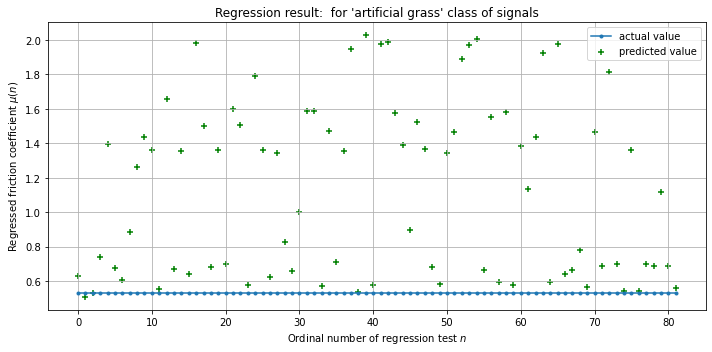

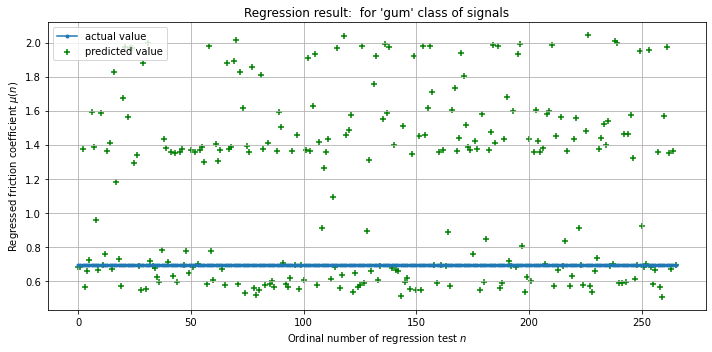

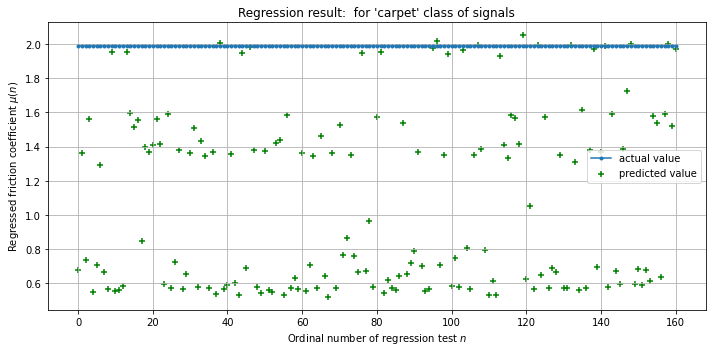

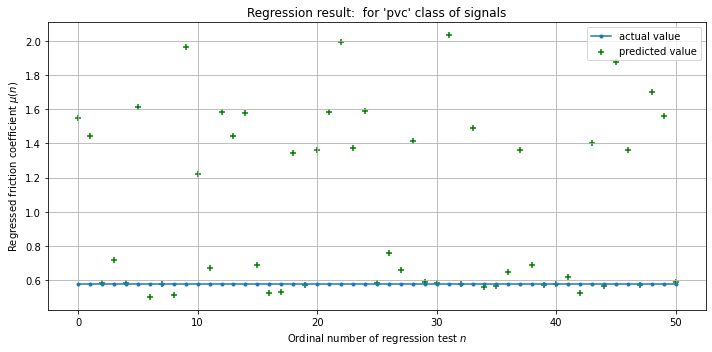

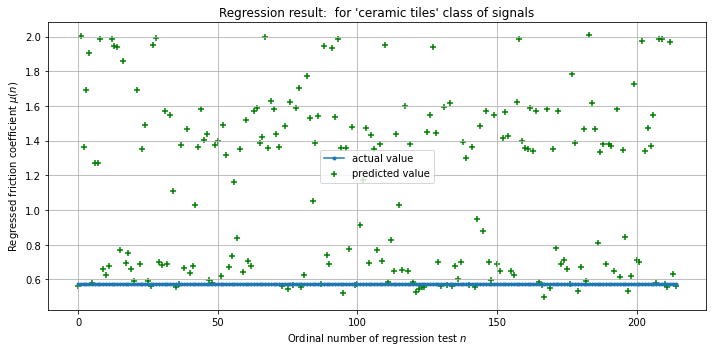

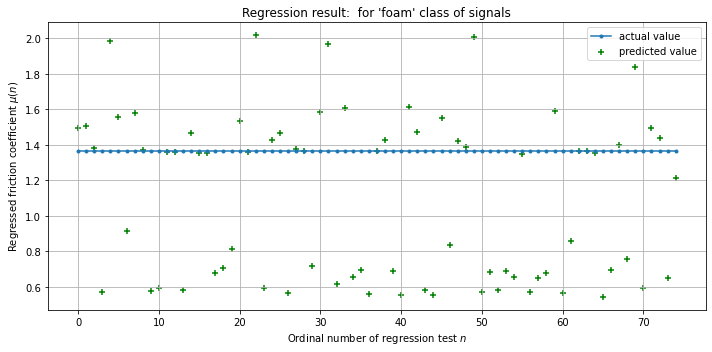

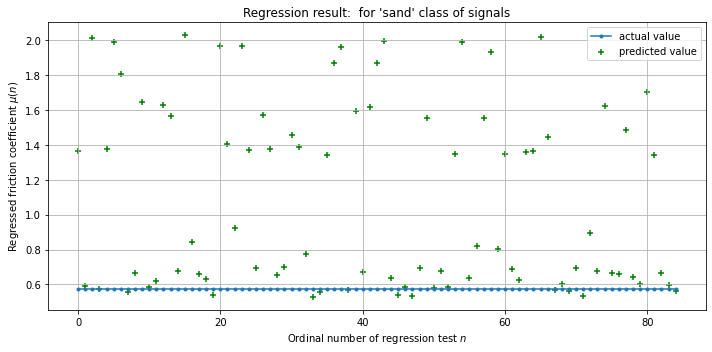

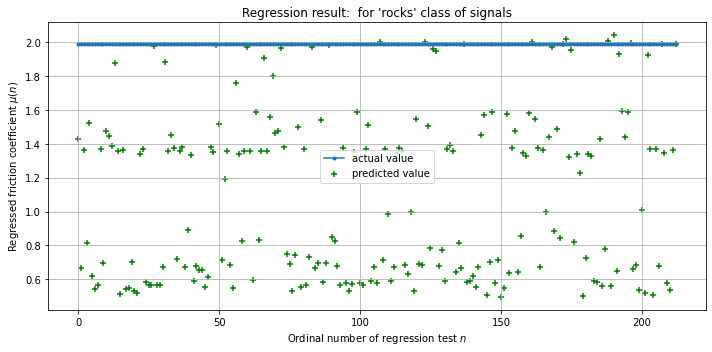

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

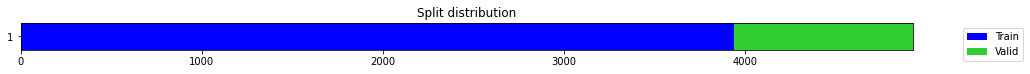


--- average values ---
For class - 0 average regressed value:  1.242030106145415
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.1935826376462595
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  18.447648141433305 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  24.825426845659525 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  21.636537493546413
--- standard_deviations ---
For class - 0 stdev:  0.40288270851428065
For class

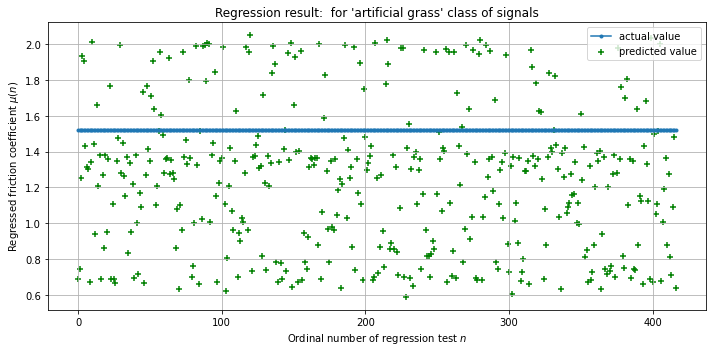

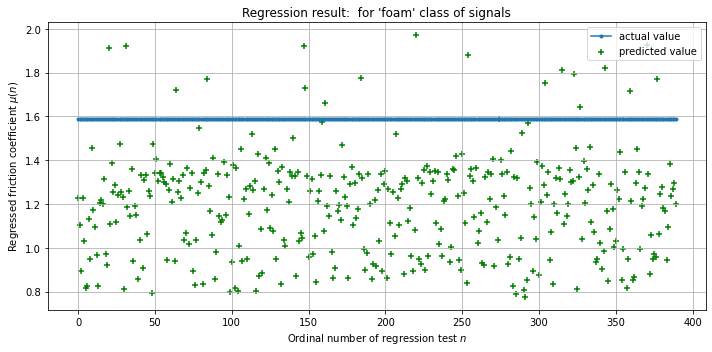

In [ ]:
evaluate_architecture_performance(mWDN, 'tst_4_mwdn',  True, False,350)

# Architecture 5: MLP <- DONE

https://en.wikipedia.org/wiki/Multilayer_perceptron

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


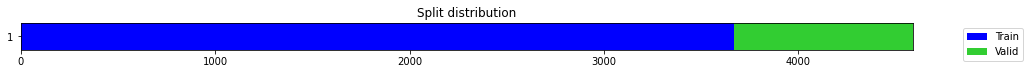


--- average values ---
For class - 0 average regressed value:  1.1254770799380978
For class - 1 average regressed value:  1.1261434106898487
For class - 2 average regressed value:  1.069661529908269
For class - 3 average regressed value:  1.0598713334868937
For class - 4 average regressed value:  1.1121730466221653
For class - 5 average regressed value:  1.0866335940361023
For class - 6 average regressed value:  1.0709833572892582
For class - 7 average regressed value:  1.1054437820900214
--- percentage differences ---
For class - 0 difference from actual value:  111.99497229978408 %
For class - 1 difference from actual value:  63.07164315310567 %
For class - 2 difference from actual value:  46.18712594884524 %
For class - 3 difference from actual value:  84.20375756139231 %
For class - 4 difference from actual value:  93.29370252171066 %
For class - 5 difference from actual value:  20.30374267092028 %
For class - 6 difference from actual value:  86.13500758565056 %
For class - 7 diff

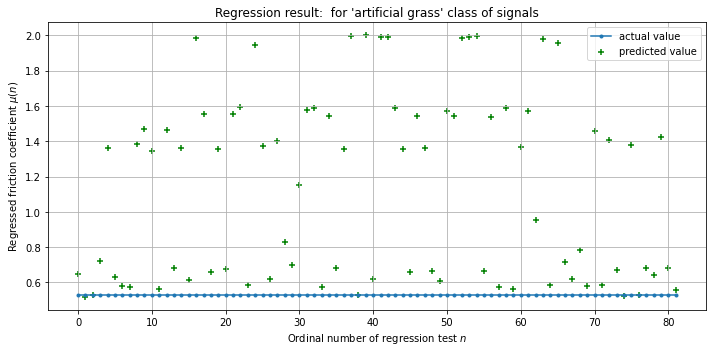

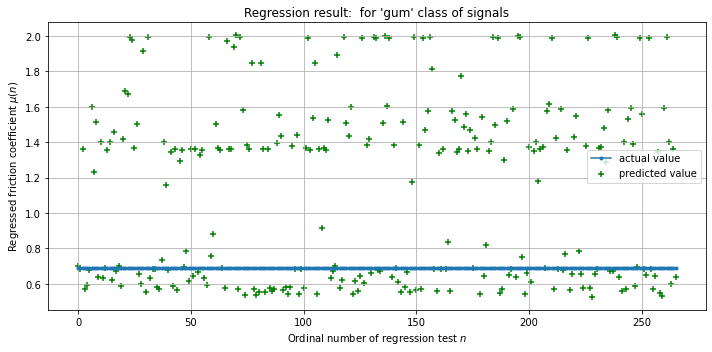

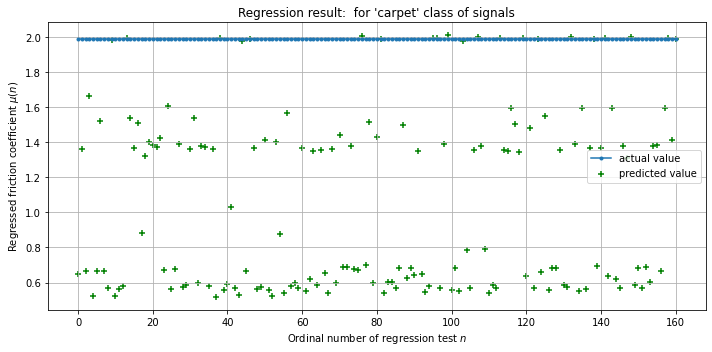

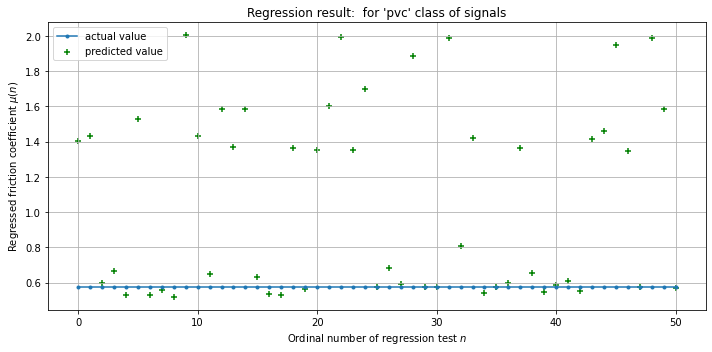

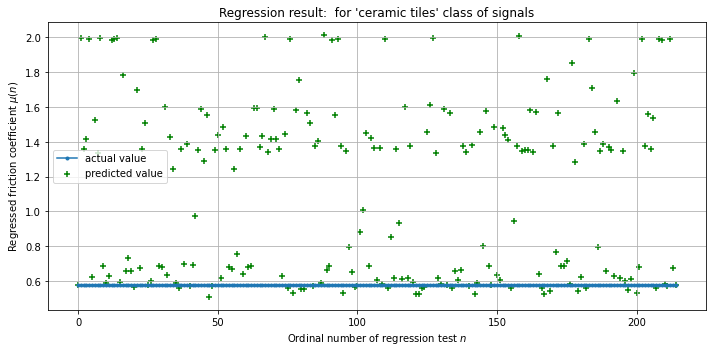

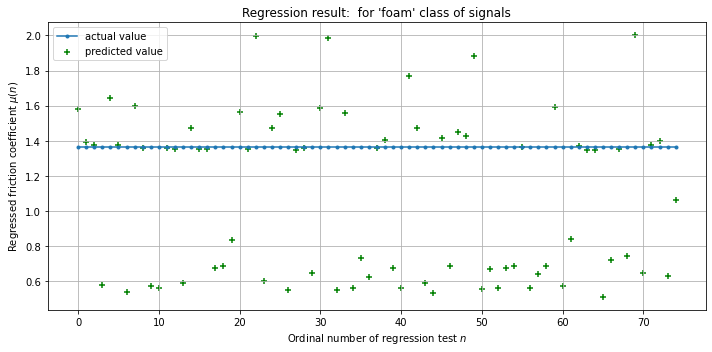

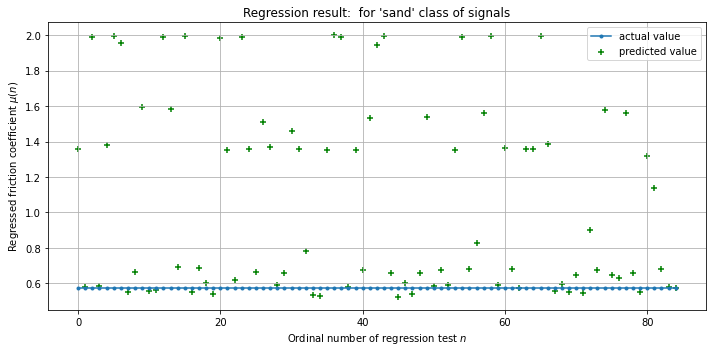

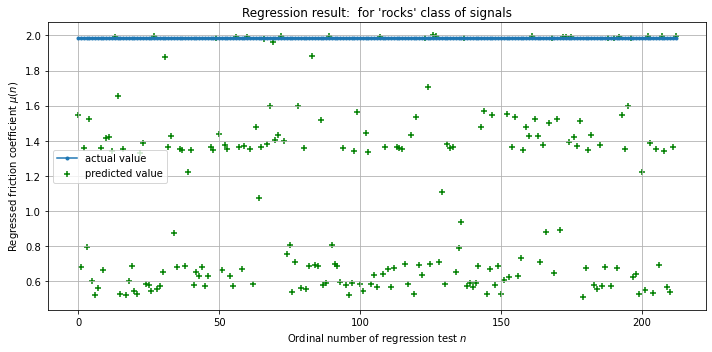

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

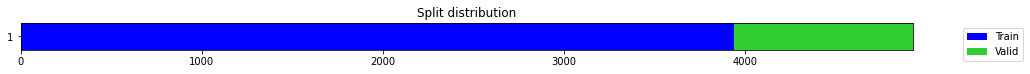


--- average values ---
For class - 0 average regressed value:  1.2301046705360321
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.2459787494097
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  19.23067853342706 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  21.52539950567478 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  20.37803901955092
--- standard_deviations ---
For class - 0 stdev:  0.47747428931528196
For class - 1 

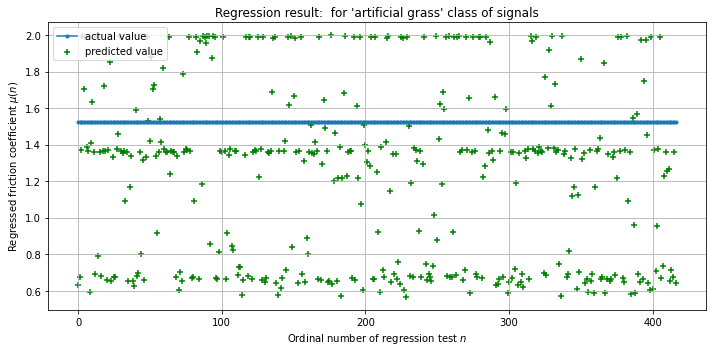

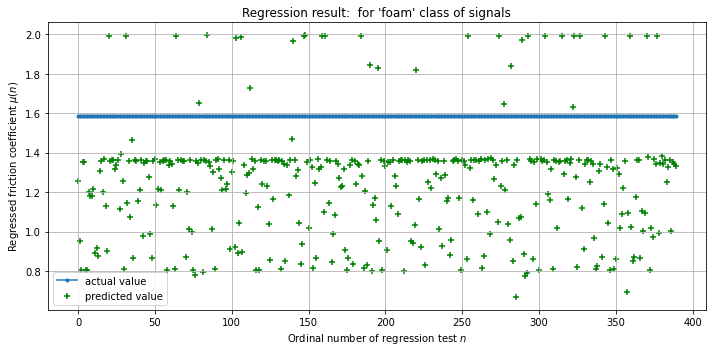

In [ ]:
evaluate_architecture_performance(MLP, 'tst_5_mlp', True,False, 350)

# Architecture 6: MINIROCKET Pytorch - done

ROCKET (RandOm Convolutional KErnel Transform) functions for univariate and multivariate time series.

Data shape:

1. Samples
2. Variables
3. Length (aka time or sequence steps)

In train_ds -> x array length = 3443 shape elements in x = (6, 160)
In train_ds -> y array length = 3443 y[0] = 0.5753798660343042
In train_ds -> y array length = 3443 y_labels[0] = 4
In val_ds -> x array length = 1148 shape elements in x = (6, 160)
In val_ds -> y array length = 1148 y[0] = 1.5229850247598293
In val_ds -> y array length = 1148 y_labels[0] = 0
In test_ds -> x array length = 1148 shape elements in x = (6, 160)
In test_ds -> y array length = 1148 y[0] = 0.5753798660343042
In test_ds -> y array length = 1148 y_labels[0] = 4


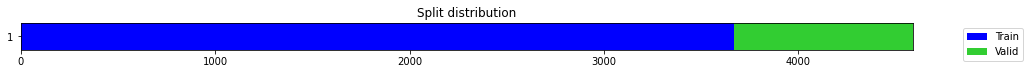


--- average values ---
For class - 0 average regressed value:  1.2014231883534572
For class - 1 average regressed value:  1.1849482211851536
For class - 2 average regressed value:  1.1891627404260339
For class - 3 average regressed value:  1.0983820732902079
For class - 4 average regressed value:  1.1897056036217268
For class - 5 average regressed value:  1.169160515467326
For class - 6 average regressed value:  1.1152022873654086
For class - 7 average regressed value:  1.1739661109419497
--- percentage differences ---
For class - 0 difference from actual value:  126.30018867138362 %
For class - 1 difference from actual value:  71.58689705571666 %
For class - 2 difference from actual value:  40.17522086415505 %
For class - 3 difference from actual value:  90.89685582163247 %
For class - 4 difference from actual value:  106.76872338643778 %
For class - 5 difference from actual value:  14.251024622207876 %
For class - 6 difference from actual value:  93.82017918905075 %
For class - 7 di

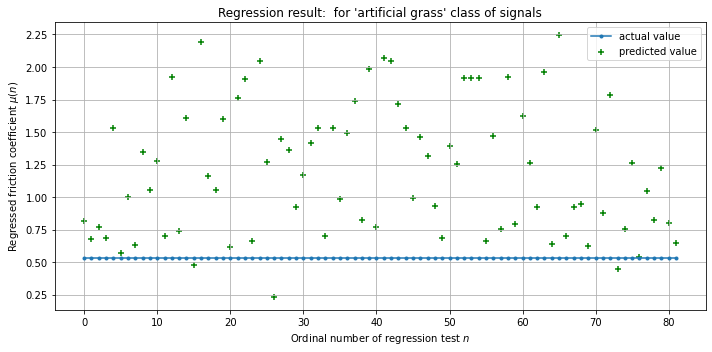

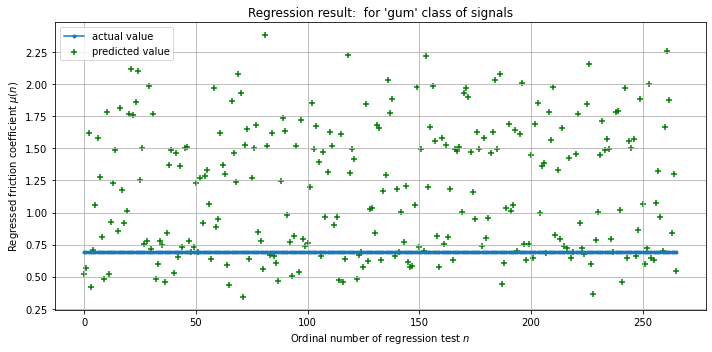

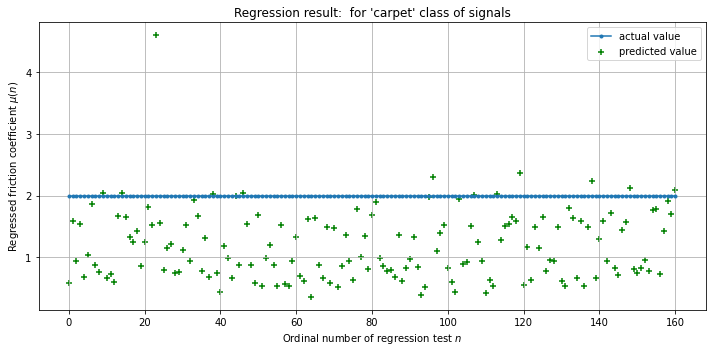

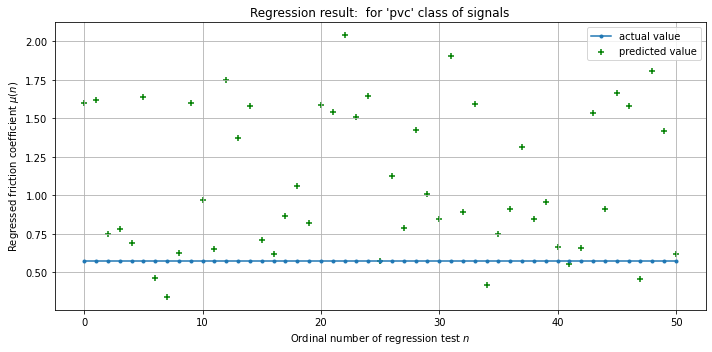

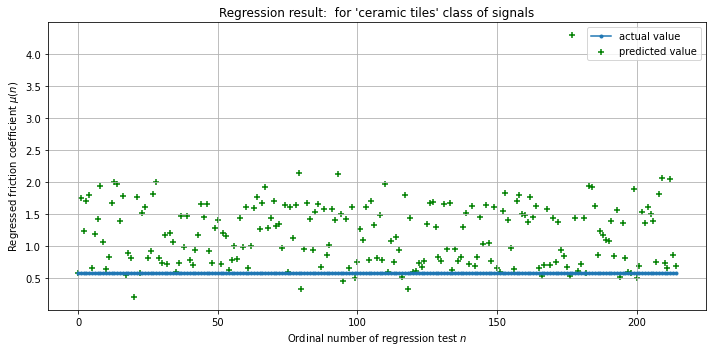

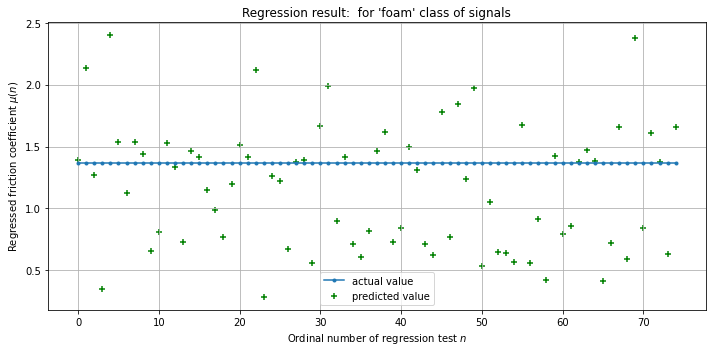

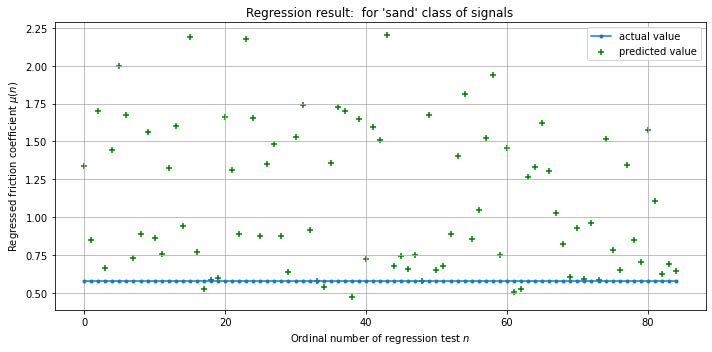

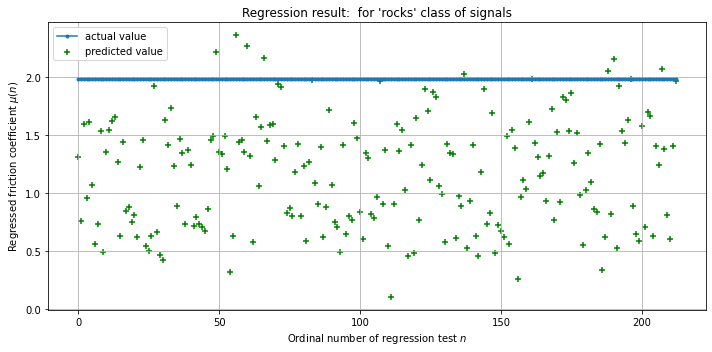

In train_ds -> x array length = 2959 shape elements in x = (6, 160)
In train_ds -> y array length = 2959 y[0] = 0.5753798660343042
In train_ds -> y array length = 2959 y_labels[0] = 4
In val_ds -> x array length = 986 shape elements in x = (6, 160)
In val_ds -> y array length = 986 y[0] = 0.6905819975288582
In val_ds -> y array length = 986 y_labels[0] = 7
In test_ds -> x array length = 161 shape elements in x = (6, 160)
In test_ds -> y array length = 161 y[0] = 1.5229850247598293
In test_ds -> y array length = 161 y_labels[0] = 0
In test_ds -> x array length = 987 shape elements in x = (6, 160)
In test_ds -> y array length = 987 y[0] = 0.5753798660343042
In test_ds -> y array length = 987 y_labels[0] = 4
In train_ds -> x array length = 484 shape elements in x = (6, 160)
In train_ds -> y array length = 484 y[0] = 1.5229850247598293
In train_ds -> y array length = 484 y_labels[0] = 0
In val_ds -> x array length = 162 shape elements in x = (6, 160)
In val_ds -> y array length = 162 y[0] 

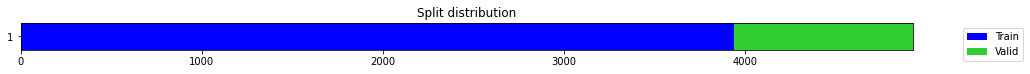


--- average values ---
For class - 0 average regressed value:  1.2994771738418287
For class - 1 average regressed value:  nan
For class - 2 average regressed value:  nan
For class - 3 average regressed value:  nan
For class - 4 average regressed value:  nan
For class - 5 average regressed value:  1.275499338675768
For class - 6 average regressed value:  nan
For class - 7 average regressed value:  nan
--- percentage differences ---
For class - 0 difference from actual value:  14.675643376943071 %
For class - 1 difference from actual value:  nan %
For class - 2 difference from actual value:  nan %
For class - 3 difference from actual value:  nan %
For class - 4 difference from actual value:  nan %
For class - 5 difference from actual value:  19.66612505969464 %
For class - 6 difference from actual value:  nan %
For class - 7 difference from actual value:  nan %
Avg percentage difference:  17.170884218318854
--- standard_deviations ---
For class - 0 stdev:  0.41555471041554715
For class 

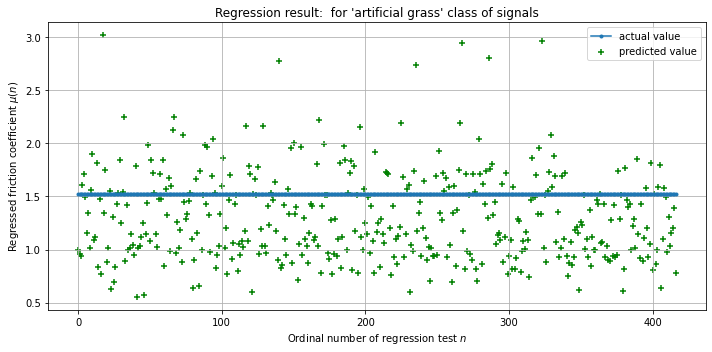

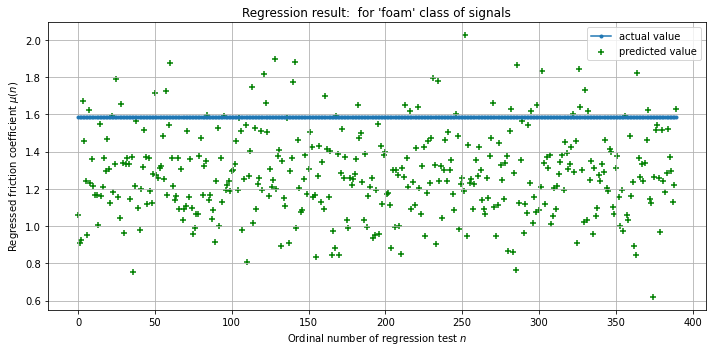

In [ ]:
evaluate_architecture_performance(MiniRocket, 'tst_6_minirocket',  True,False,350)